# Reduce Test Data

This notebook will guide users through reducing the test data created by `create_test_data.py`. The simulated data contain 1000 images for each of OPTICam's three cameras. The observations have a 1 s cadence, and there are two variable sources in the field (one periodic, one aperiodic). Unlike real OPTICam data, these test data do not contain position-dependent systematics or vignetting, and there are no alignments required between images. However, the images do include position- and time-dependent backgrounds, and white noise.

The first step in reducing any OPTICam data is to initialise a `Reducer` object:

In [1]:
from opticam_new import Reducer

name = "Test"
date = "20240101"

reducer = Reducer(
    data_directory=f"/mnt/SATA1/Data/Opticam/Raw/{name}/{date}/",  # path to the simulated data
    out_directory=f"/home/zac/Documents/University/PhD/Opticam_new/Reduced/{name}/{date}/",  # path to where output will be saved
    show_plots=True,
    )

[OPTICAM] Scanning files ...


100%|██████████| 16/16 [00:00<00:00, 109.84it/s]


[OPTICAM] Done.
[OPTICAM] Binning: 8x8
[OPTICAM] Filters: g-band, i-band, r-band
[OPTICAM] Read transforms from file.
[OPTICAM] Read g-band catalog from file.
[OPTICAM] Read i-band catalog from file.
[OPTICAM] Read r-band catalog from file.


We can see that the test data use an 8x8 binning, meaning the images are 256 pixels x 256 pixels. The observation times of the test data correspond to January 1st 2024, and the three filters used are "g", "i", and "r".

Let's initialise catalogs for each filter:

In [2]:
reducer.initialise_catalogs()

[OPTICAM] Catalogs already exist. To overwrite, set overwrite to True.


We can see that all six sources have been identified in the catalog. In this example, the source labelling is consistent across the catalogs; this is because there are no field-of-view or pixel-scale differences between the simulated cameras. In practise, the source labelling will not usually be consistent across the catalogs, and so care must be taken when performing differential photometry that the same sources are being used for each filter.

With our catalogs defined, we can now perform aperture photometry. In this example, we will leverage all of the different photometry options currently available in `opticam_new`: 'aperture', 'annulus', 'normal', and 'optimal'. For more information about the different photometries, see the photometry tutorial. For 'aperture' and 'annulus' photometries, we need to call the `forced_photometry()` method:

In [3]:
reducer.forced_photometry(phot_type='both')

[OPTICAM] Extracting aperture and annulus fluxes ...
[OPTICAM] g-band light curves already exist. To overwrite, set overwrite to True.
[OPTICAM] i-band light curves already exist. To overwrite, set overwrite to True.
[OPTICAM] r-band light curves already exist. To overwrite, set overwrite to True.


For 'normal' and 'optimal' photometries, we need to call the `photometry()` method:

In [4]:
reducer.photometry(phot_type='both')

[OPTICAM] Extracting normal and optimal fluxes ...
[OPTICAM]  Existing g-band light curves detected. To overwrite these files, set overwrite to True.
[OPTICAM]  Existing i-band light curves detected. To overwrite these files, set overwrite to True.
[OPTICAM]  Existing r-band light curves detected. To overwrite these files, set overwrite to True.


Photometries available via the 'photometry()' method require fitting for the source positions in each image; in some cases, this can mean that some sources do not have measureable fluxes in all images (depending on the value of 'threshold' specified when instancing a 'Reducer()' object). As we can see above, all sources have the nominal 1000 detections, matching the number of observations. For performing differential photometry, the target source and all comparison sources must have matching detections.

In this example, we know that two sources are variable. We'll' assume that one of these variable stars is the star we're interested in, and so that will be our target source (source 2). For the other variable star, we'll have to see if we can find it without prior knowledge. In practise, the choice of reference star(s) is cruical for obtaining a quality final light curve. Even for stars that are known to be constant emitters, it is important to consider things like where the source is on the CCD (since the systematics can vary with posiiton). To choose suitable comparison sources, it is most instructive to inspect the raw light curves and choose those that look most similar and/or are close to the target source in the image. Let's now produce a relative light curve for source 2 using all remaining sources for comparison. For this example, we will use the 'annulus' light curves:

['g-band', 'i-band', 'r-band']


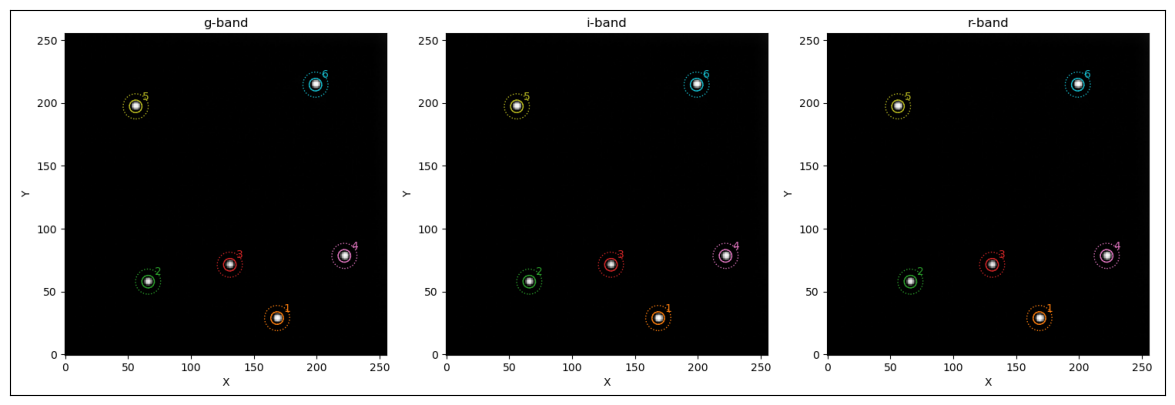

In [5]:
from opticam_new import Photometer

photometer = Photometer(reducer.out_directory)

i-band 2 [1, 3, 4, 5, 6]
r-band 2 [1, 3, 4, 5, 6]


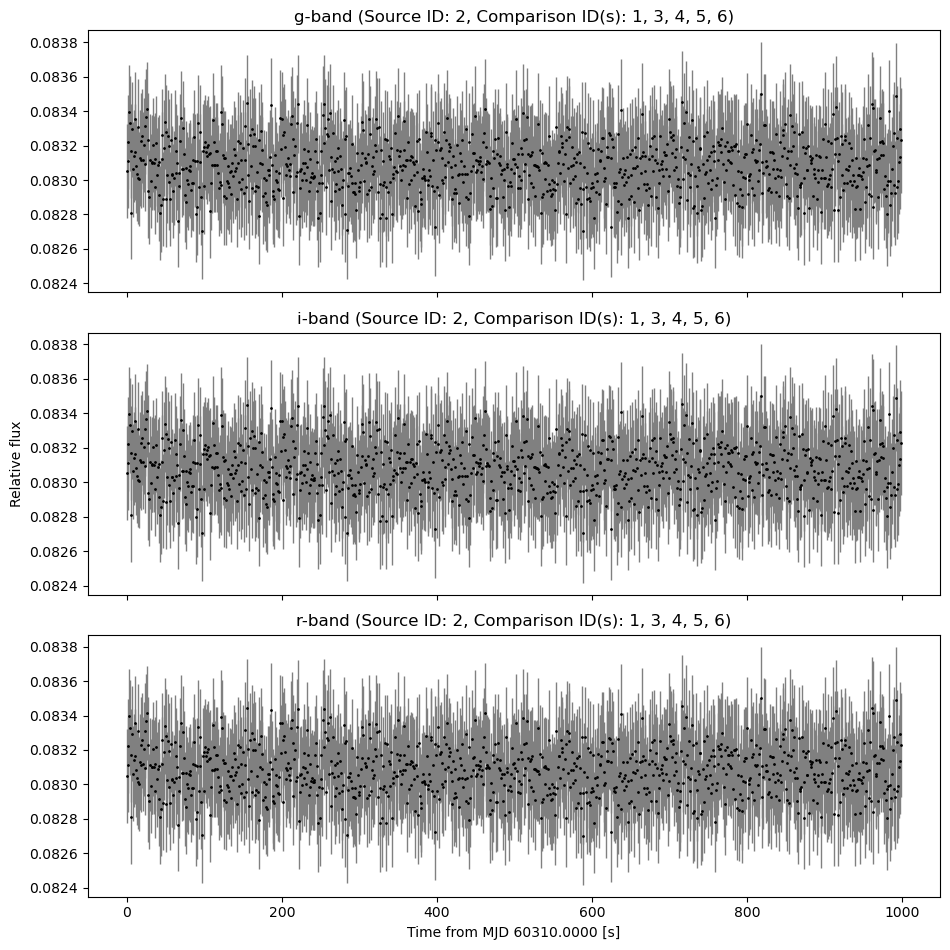

In [6]:
target = 2
comparisons = [1, 3, 4, 5, 6]

analyser = photometer.get_relative_light_curve('g-band', target, comparisons, phot_type='annulus', prefix="test",
                                               match_other_cameras=True, show_diagnostics=False)

To help identify suitable comparison sources, residual plots are created between the target and each comparison source's normalized light curves. These plots are saved in `out_directory/relative_light_curves/diag`. Good comparison sources should have similar systematics to the target source, resulting in similarly shaped light curves (ignoring any intrinsic variability from the target).

The target source has a periodic signal with a period of 50 s (0.02 Hz), let's see if we can find this signal in the power spectrum:

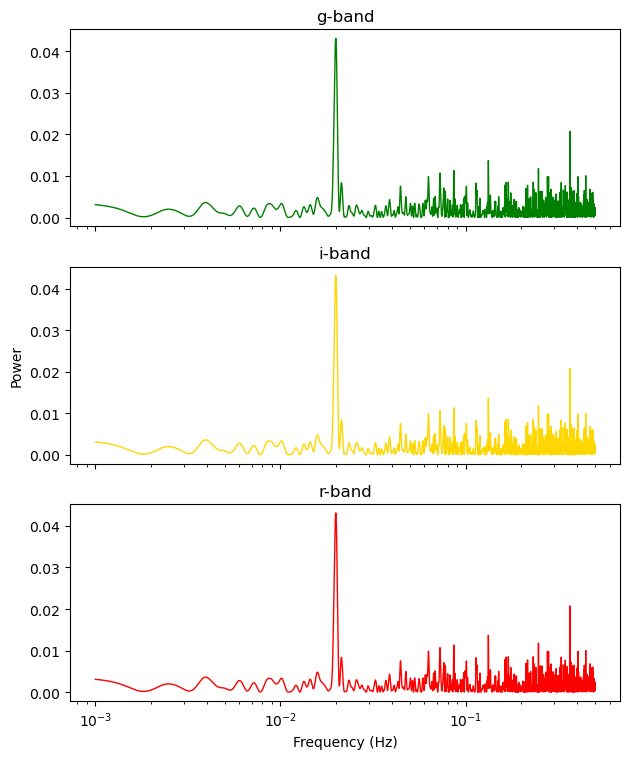

In [7]:
frequencies, periodograms = analyser.lomb_scargle(scale='log')

As we can see, the 50 s period is recovered quite clearly. However, since all the sources in each image have the nominal 1000 detections, we might see an improved signal-to-noise ratio if we instead use the 'optimal' light curves:

i-band 2 [1, 3, 4, 5, 6]
r-band 2 [1, 3, 4, 5, 6]


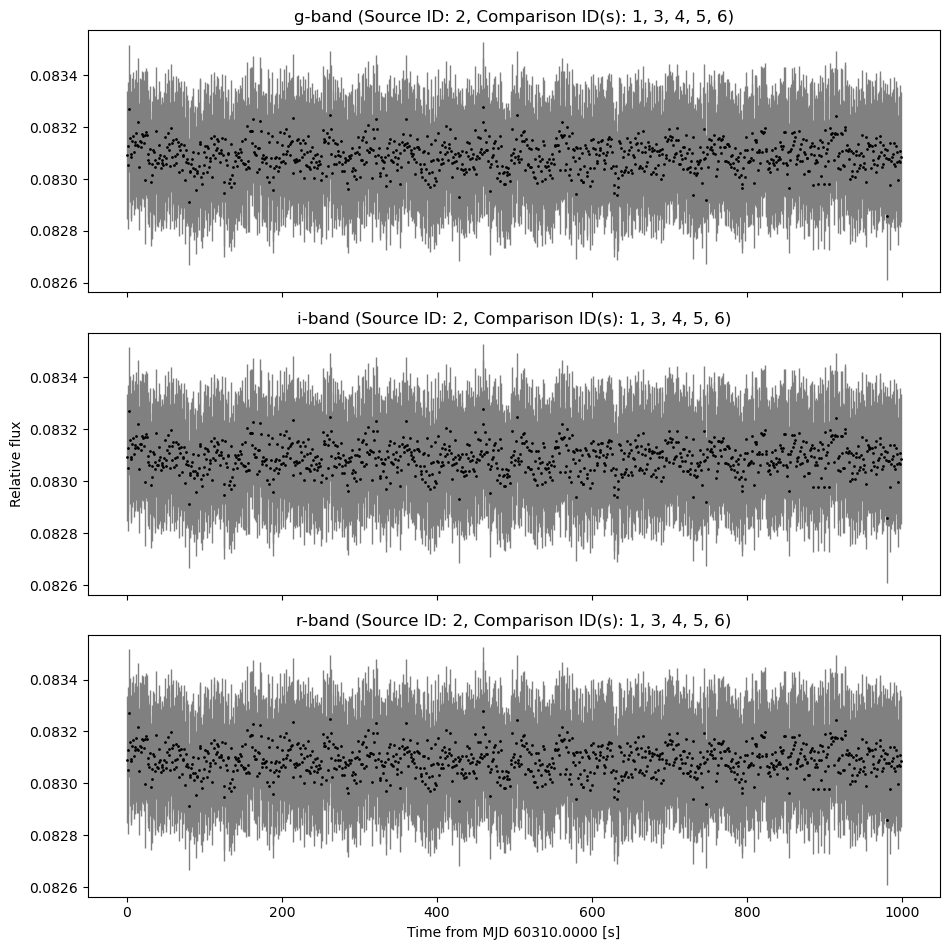

In [8]:
analyser = photometer.get_relative_light_curve('g-band', target, comparisons, phot_type='optimal', prefix="test",
                                               match_other_cameras=True, show_diagnostics=False)

It should be immediately clear that the periodic signal is clearer in the 'optimal' relative light curve. Let's check the power spectrum:

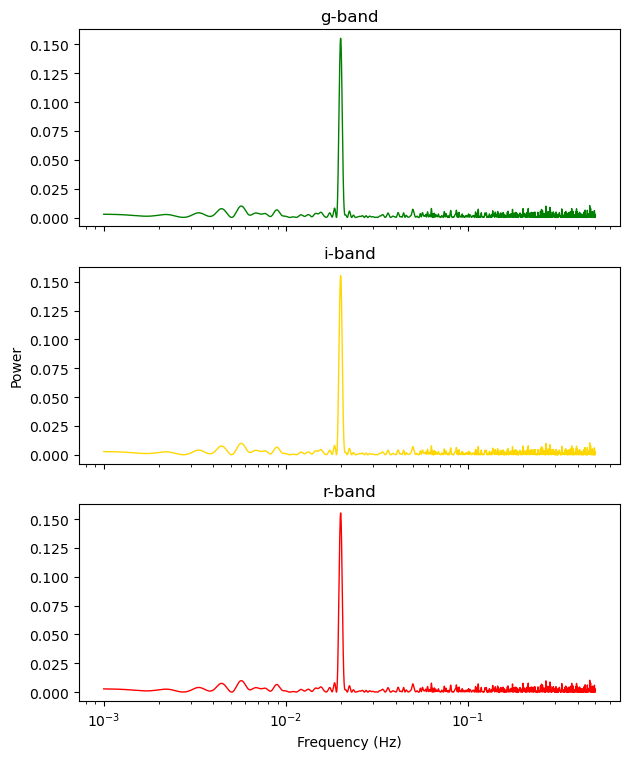

In [9]:
frequencies, powers = analyser.lomb_scargle(scale='log')

As we can see, the signal is much stronger.

And that's it! Hopefully, `opticam_new` makes reducing OPTICam data nice and easy! For more specific examples explaining the different reduction methods, see the dedicated tutorials.